<b><h1>LDS model for wood species identification</h1></b>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
import numpy as np
import scipy as sp
from hottbox.algorithms.decomposition import HOSVD
from hottbox.core import Tensor
from PIL import Image, ImageDraw
import os
import cv2
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
# basic parameters
train_map = 'data/wood/Train-Wood-Species-Map.txt'
test_map = 'data/wood/Test-Wood-Species-Map.txt'
image_width = 200
image_height = 200
num_channles = 3
step_size = 30
num_train_images = 5708
num_test_images  = 2836

<b><h1>Usefull Functions</h1></b>

In [3]:
def get_rhi(img_path, show=True):
    rhi = list()
    img_path = '{}_Salient{}'.format(img_path[0:12],img_path[12:])
    img = mpimg.imread(img_path)
    if show:
        plt.imshow(img)
    for i in range(0,image_width-step_size,step_size//3):
        for j in range(0,image_height-step_size, step_size//3):
            datarg = np.sum(img[i:i+step_size, j:j+step_size, 0:2], axis=-1)
            datagb = np.sum(img[i:i+step_size, j:j+step_size, 1:-1], axis=-1)
            zero_numrg = np.count_nonzero(datarg.flatten()==0)
            zero_numgb = np.count_nonzero(datagb.flatten()==0)
            if zero_numrg == 0 and zero_numgb == 0:
                rhi.append((i,j))
    if len(rhi) >=20:
        rhi = rhi[0:20]
    return rhi


def get_imgs(mapfile):
    with open(mapfile,'r') as f:
        lines = f.readlines()
        filenames_idx = list()
        for line in range(len(lines)):
            filenames_idx.append(lines[line].split('\t'))    
        f.close()
        return filenames_idx
        
        
def LDS(img_path, rhi):
#     LDS parameters
    algorithm = HOSVD()
    ml_rank = (30,30,3)
    
#     Opening Image
    img_path = '{}_Salient{}'.format(img_path[0:12],img_path[12:])
    img = mpimg.imread(img_path)
    
#     Calculating LDS parameters
    M_mat = np.zeros((ml_rank[2], ml_rank[2], 2* len(rhi)))
    for region in range(0,2*len(rhi),2):
        data = img[rhi[region//2][0]:rhi[region//2][0] + step_size, rhi[region//2][1]:rhi[region//2][1] + step_size, :]
        data = Tensor(data)
        tensor_HOSVD = algorithm.decompose(data, ml_rank)
        #### calculating C
        M_mat[:,:,region] = (tensor_HOSVD.fmat)[2]
        #### calculating A
        X = ((tensor_HOSVD.core).mode_n_product(tensor_HOSVD.fmat[0], mode=0)).mode_n_product(tensor_HOSVD.fmat[1], mode=1)
        X_3 = X.unfold(mode=2)
        # creating transition matrix components
        X1 = X_3.data[:,1:]
        X2 = X_3.data[:,:-1]
        #calculating transition matrix
        M_mat[:,:,region+1] = np.dot(np.dot(X2,X1.T), np.linalg.inv(np.dot(X1,X1.T)))
    return M_mat


def martinDist(M1, M2):
    
    reject = 0 
    #  combining the A and C matrices
    C = np.concatenate((M1[:,:,0], M2[:,:,0]), axis=-1)
    A = np.zeros((M1.shape[0]*2, M2.shape[1]*2))
    A[0:M2.shape[1], 0:M1.shape[0]] = M1[:,:,1]
    A[M2.shape[1]:,M1.shape[0]:] = M2[:,:,1]
    
    # range check
    eigvals, _ = np.linalg.eig(A)
    for i in range(eigvals.shape[0]):
        for j in range(eigvals.shape[0]):
            mul = eigvals[i] * eigvals[j]
            if mul<1.000001 and mul>0.999999:
                reject = 1
    # Lyapunov equation
    if reject == 0:
        Q = np.dot(-C.T, C)
        P = sp.linalg.solve_discrete_lyapunov(A,Q)
        P11 = P[:M1.shape[0], :M1.shape[0]]
        P12 = P[M1.shape[0]:,:M1.shape[0]]
        P21 = P[:M1.shape[0],M1.shape[0]:]
        P22 = P[M1.shape[0]:, M1.shape[0]:]
        
        P11inv = np.linalg.inv(P11)
        P22inv = np.linalg.inv(P22)
        
        #calculating martin distance
        pm = np.dot(np.dot(P11inv,P12),np.dot(P22inv,P21))
        dmVals, _ = np.linalg.eig(pm)
        distMartin = -np.log(np.prod(np.absolute(dmVals)))
    else:
        distMartin = 10**100
    if distMartin < 10**-15:
        distMartin = 0
    return distMartin


# calculate pairwise distance for all input data (very long computation)
# input must be a 3d tensor 
# change line 2 of function to use 2d matrix
def getPairwiseDist(D):
    # get shape of input data
    r, c, d = D.shape
    # create output array for data
    pairWiseDists = np.zeros((d//2,d//2))
    # calcualte all pairWiseDists
    for ref in range(0,d,2):
        for point in range(0,d,2):
            pairWiseDists[ref//2, point//2] = martinDist(D[:, :, ref:ref+2], D[:, :, point:point+2])
    return pairWiseDists

# use 64 clusters and different values
def Kmedoids(data, k, maxit=200):
    # determine dimensions of distance matrix D
    m, n = data.shape

    if k > n:
        raise Exception('too many medoids')

    # find a set of valid initial cluster medoid indices since we
    # can't seed different clusters with two points at the same location
    valid_medoid_inds = set(range(n))
    invalid_medoid_inds = set([])
    rs,cs = np.where(data==0)
    # the rows, cols must be shuffled because we will keep the first duplicate below
    index_shuf = list(range(len(rs)))
    np.random.shuffle(index_shuf)
    rs = rs[index_shuf]
    cs = cs[index_shuf]
    for r,c in zip(rs,cs):
        # if there are two points with a distance of 0...
        # keep the first one for cluster init
        if r < c and r not in invalid_medoid_inds:
            invalid_medoid_inds.add(c)
    valid_medoid_inds = list(valid_medoid_inds - invalid_medoid_inds)

    if k > len(valid_medoid_inds):
        raise Exception('too many medoids (after removing {} duplicate points)'.format(
            len(invalid_medoid_inds)))
    # randomly initialize an array of k medoid indices
    M = np.array(valid_medoid_inds)
    np.random.shuffle(M)
    M = np.sort(M[:k])
    # create a copy of the array of medoid indices
    Mnew = np.copy(M)
    
    # initialize a dictionary to represent clusters
    C = {}
    for t in range(maxit):
        # determine clusters, i. e. arrays of data indices
        J = np.argmin(data[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]
        # update cluster medoids
        for kappa in range(k):
            J = np.mean(data[np.ix_(C[kappa],C[kappa])],axis=1)
            j = np.argmin(J)
            Mnew[kappa] = C[kappa][j]
        np.sort(Mnew)
        # check for convergence
        if np.array_equal(M, Mnew):
            break
        M = np.copy(Mnew)
    else:
        # final update of cluster memberships
        J = np.argmin(data[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

    # return results
    return M, C


# really shit shit code below be warned
def genTrain_hist(medoids, features, features_used, info_mat):
    # features_used are the features used during clustering
    
    #basic shape parameters
    num_images = info_mat.shape[0]
    num_medoids = medoids.size
    # intializing data matrix
    training_hist = np.zeros((num_images, medoids.size))
    
    # itterate over all image data
    for img in range(num_images):
        if img % 1000 == 0 and img != 0:
            print('Processed 1000 images')
        cumsum = 0
        num_rhi = info_mat[img,1].astype(int)
        dists = np.zeros((medoids.size))
        #itterate over all regions of interest
        for rhi in range(cumsum, cumsum + num_rhi, 1):
            # itterate over all medoids
            for med in range(num_medoids):
                dists[med] = martinDist(features[:,:, 2*rhi:(2*rhi)+2], features_used[:,:, medoids[med]:medoids[med]+2])
            closest = np.argmin(dists[0:num_medoids])
            training_hist[img, closest] = training_hist[img, closest] + 1
        cumsum = cumsum + num_rhi
    return training_hist

<b><h1>Simple Example using single image</h1></b>

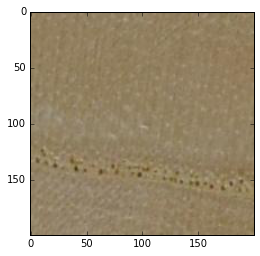

In [20]:
i = 4000
imgs_lbl = get_imgs(train_map)
img_path = imgs_lbl[i][0]
img = mpimg.imread(img_path)
plt.imshow(img)

Found 6 rhi
[(130, 20), (130, 30), (130, 120), (140, 140), (140, 150), (140, 160)]


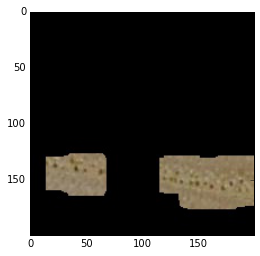

In [21]:
# get tuples containing location of all rhi
rhi = get_rhi(img_path, show=True)
print('Found {} rhi'.format(str(len(rhi))))
print(rhi)

In [23]:
# calculate A and C Matrices for all regions of a single image 
# even indices are C matrices and odd indices are A matrices
M = LDS(img_path, rhi)
print(M)

[[[-6.65468335e-01  9.97611403e-01 -6.68916464e-01  9.98081505e-01
   -6.72121465e-01  9.97434318e-01 -6.76632881e-01  9.97922301e-01
   -6.78576708e-01  9.97642636e-01 -6.80197179e-01  9.96896625e-01]
  [ 4.68450636e-01 -3.66397649e-01  4.73242611e-01 -2.83115834e-01
    4.01075602e-01 -6.38741493e-01  4.75549191e-01 -8.77366185e-01
    5.27519345e-01 -8.85418117e-01  5.24666488e-01 -1.21456540e+00]
  [ 5.81124723e-01 -2.18090510e+00  5.73229611e-01 -5.40048659e-01
    6.22407198e-01 -6.55920327e-01  5.62157750e-01 -9.07484591e-02
    5.11133194e-01 -6.75452966e-03  5.11914968e-01 -2.22076535e-01]]

 [[-5.89677453e-01 -4.20564727e-04 -5.88502765e-01 -3.35837627e-04
   -5.96299350e-01 -4.06631181e-04 -5.93495250e-01 -3.70440161e-04
   -5.92387617e-01 -4.36711940e-04 -5.93234241e-01 -5.99657942e-04]
  [ 1.47391275e-01  9.19383764e-01  1.33946881e-01  9.26744044e-01
    2.05128193e-01  8.12506497e-01  9.96453166e-02  8.06931973e-01
    1.84037685e-02  7.87975252e-01  1.62147135e-02  7.22

<b><h1>Extracting features from all training images</h1></b>

In [40]:
#### LONG ONLY RUN NOT NECCESSARY FEATURES MAT ALREADY SAVED IN: 'LDS_data' directory
img_lbl = get_imgs(train_map)
lbl_rhi_mat = np.zeros((num_train_images,2))
features = np.zeros((3,3,0))

for item in range(len(img_lbl)):
    rhi = get_rhi(img_lbl[item][0], show=False)
    if len(rhi) != 0:
        M = LDS(img_lbl[item][0], rhi)
        features = np.concatenate((features, M), axis=-1)
        lbl_rhi_mat[item,0] = int(img_lbl[item][1])
        lbl_rhi_mat[item,1] = len(rhi)  
inf_mat = np.cumsum(info_mat[:,1]).reshape(lbl_rhi_mat.shape[0],1)
lbl_rhi_mat = np.concatenate((lbl_rhi_mat, inf_mat), axis=-1)
print('Done !')

Done !


In [41]:
# # # saving A/C matrix data
# np.save('LDS_data/features.npy', features)
# np.save('LDS_data/inf_mat.npy', lbl_rhi_mat)

In [4]:
# loading saved data
try:
    features = np.load('LDS_data/features.npy')
    info_mat = np.load('LDS_data/inf_mat.npy')
    print('Great Success')
except:
    print('No files with this name found')
print(features.shape)

Great Success
(3, 3, 197142)


In [6]:
# i and j must be even
i = 2
j = 2
# calcualtes marting distance between chosen points
M1 = features[:,:,i:i+2]
print(M1.shape)
M2 = features[:,:,j:j+2]
P = martinDist(M1,M2)
print(P)

(3, 3, 2)
0


In [5]:
# randomly select some of the features
num_feat = 500
feature_ind = (np.random.choice(features.shape[2]//2, num_feat) * 2).astype(int)
features_used = np.zeros((3,3,num_feat * 2))
print('Randonmly selecting {} features'.format(num_feat))
for i in range(0,feature_ind.size):
    features_used[:,:,i*2:(i*2)+2] = features[:,:, feature_ind[i]:feature_ind[i] + 2]
# calculate pairwise distance for all features
print('Calculating Pairwise Martin Distance')
pairs = getPairwiseDist(features_used)
print('Done')

Randonmly selecting 500 features
Calculating Pairwise Martin Distance
Done


In [6]:
medoids, clusters = Kmedoids(pairs, 32)
medoids = medoids * 2
print('Medoids: \n\n')
print(medoids)
print('\n\n')
print('Clusters: \n\n')
print(clusters)

Medoids: 


[ 14  88 122 202 230 564 380 272 394 334  30   6 438 494 534 548 568 246
 342 422 714 904 150 796 804 808 878 764 562 264 940 976]



Clusters: 


{0: array([  1,   7,  10,  40,  42,  83, 142, 169, 175, 187, 216, 233, 235,
       245, 279, 324, 333, 336]), 1: array([  6,  12,  29,  34,  44,  47,  49,  51,  77,  84, 126, 183, 249,
       330, 411, 441, 449, 453, 469]), 2: array([ 61, 296, 309, 325, 340, 468, 498]), 3: array([ 50,  90,  98, 101, 146, 188, 189, 193, 262, 289, 491]), 4: array([ 21,  43, 103, 112, 115, 116, 151, 173, 185, 263, 273, 294, 307,
       310, 419, 434, 456, 477]), 5: array([108, 117, 141, 165, 241, 250, 257, 282, 367, 378, 383, 408, 420,
       436, 462]), 6: array([ 24,  56,  60,  85, 106, 119, 139, 156, 166, 190, 195, 288, 350,
       371, 460, 463, 475, 490, 495]), 7: array([ 66, 136, 170, 210, 251, 319, 331, 440, 494]), 8: array([  0,  16,  58,  69,  72,  74,  79,  96, 128, 133, 135, 137, 144,
       172, 174, 197, 213, 217, 269, 290, 298, 312, 31

In [7]:
print('generate Histograms for all training images')
hist = genTrain_hist(medoids, features, features_used, info_mat)
print(hist.shape)
print('Done')

generate Histograms for all training images
Processed 1000 images
Processed 1000 images
Processed 1000 images
Processed 1000 images
Processed 1000 images
(5708, 32)
Done


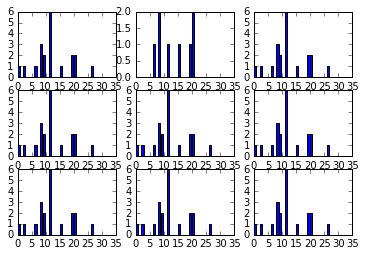

In [120]:
np.save('LDS_data/hist_train.npy', hist)
fig = plt.figure()
ax1 = fig.add_subplot(331)
ax1.bar(np.arange(hist.shape[1]), hist[0,:])
ax2 = fig.add_subplot(332)
ax2.bar(np.arange(hist.shape[1]), hist[1,:])
ax3 = fig.add_subplot(333)
ax3.bar(np.arange(hist.shape[1]), hist[2,:])
ax4 = fig.add_subplot(334)
ax4.bar(np.arange(hist.shape[1]), hist[3,:])
ax5 = fig.add_subplot(335)
ax5.bar(np.arange(hist.shape[1]), hist[4,:])
ax6 = fig.add_subplot(336)
ax6.bar(np.arange(hist.shape[1]), hist[6,:])
ax7 = fig.add_subplot(337)
ax7.bar(np.arange(hist.shape[1]), hist[7,:])
ax8 = fig.add_subplot(338)
ax8.bar(np.arange(hist.shape[1]), hist[8,:])
ax9 = fig.add_subplot(339)
ax9.bar(np.arange(hist.shape[1]), hist[9,:])
fig.show()